# CARGA DE PAQUETES

In [1]:
# quitamos alertas porfavor!
import warnings
warnings.filterwarnings('ignore')

In [38]:
# librerias clasicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ploteos
from matplotlib.pyplot import xticks
%matplotlib inline

#modelos
from sklearn.model_selection import train_test_split
from  sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC
#from sklearn.linear_model import RidgeClassifier,SGDClassifier,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score,precision_score,roc_auc_score,average_precision_score
#from sklearn.neighbors import NearestNeighbors
import xgboost as xgb


### Funciones utiles

In [3]:
#funciones para medir

def mediciones(x_train,y_train,x_test,y_test,model):
    a = int(accuracy_score(y_train,model.predict(x_train))*1000)/1000
    b = int(recall_score(y_train,model.predict(x_train))*1000)/1000
    c = int(accuracy_score(y_test,model.predict(x_test))*1000)/1000
    d = int(recall_score(y_test,model.predict(x_test))*1000)/1000
    aa = int(roc_auc_score(y_train,model.predict_proba(x_train)[:,1])*1000)/1000
    cc = int(roc_auc_score(y_test,model.predict_proba(x_test)[:,1])*1000)/1000
    e = {'Entrenamiento':[a,b,aa],
         'Testeo':[c,d,cc]}
    f = pd.DataFrame(data=e,index=["Accuracy","recall","roc"])
    return f

def mediciones2(x_train,y_train,x_test,y_test,model):
    #a = int(accuracy_score(y_train,model.predict(x_train))*1000)/1000
    #b = int(recall_score(y_train,model.predict(x_train))*1000)/1000
    c = int(accuracy_score(y_test,model.predict(x_test))*1000)/1000
    d = int(recall_score(y_test,model.predict(x_test))*1000)/1000
    #aa = int(roc_auc_score(y_train,model.predict_proba(x_train)[:,1])*1000)/1000
    #cc = int(roc_auc_score(y_test,model.predict_proba(x_test)[:,1])*1000)/1000
    e = {'Testeo':[c,d]}
    f = pd.DataFrame(data=e,index=["Accuracy","recall"])
    return f

def roc_(x_train,y_train,x_test,y_test,model):
    aa = int(roc_auc_score(y_train,model.predict_proba(x_train)[:,1])*1000)/1000
    cc = int(roc_auc_score(y_test,model.predict_proba(x_test)[:,1])*1000)/1000
    e = {'Entrenamiento':[a],
         'Testeo':[c]}
    f = pd.DataFrame(data=e,index=["roc-auc"])
    return f

#mediciones(x_train,y_train,x_test,y_test,log),roc_(x_train,y_train,x_test,y_test,log)

# Preparación de datos
### LECTURA DE BASE BRUTA DESDE SAS


La base de datos se obtiene desde el SAS guardado en la carpeta diaria de Customer analytics, esta base considera todas las ofertas realizadas en kaufmann a clientes que se encuentran en el perfil, se cruza con información de venta, rvm, post venta y datos del SII.


Para el caso de puesta en prd, se consideran todas las empresas presentes en SII mas todos los clientes kaufman, mas todas las personas que están en rvm.


* Periodo de información = 2018 y 2019.
* Modelos: Utilitarios.
* Tipo Cliente: Persona y empresa.

Fuente sii:
http://www.sii.cl/sobre_el_sii/nominapersonasjuridicas.html



In [10]:
#----------------------#
# carga de informacion #
#----------------------#
#lectura de datos
df = pd.read_sas(r"file:\\10.1.1.145\datos\ANALISIS\CHILE\IMPORTER_MARKETING_CUSTOMER_ANALYTICS\DATOS\LEAD_SCORE_UTILITARIOS_PREV1.sas7bdat",
                    format='sas7bdat',encoding='latin1')
df.head()

,TIPO_CLIENTE,RUBRO_ECON,ANTIGUEDAD_E,TRAMO_VENTA,NUM_TRABAJADORES,TOTAL_UTILITARIOS,UTILITARIOS_EXCLUSION,RELEVANTE_BUSES,RELEVANTE_CAMIONES,RELEVANTE_RODADOS,...,CAMPANAS_U180D,CAMPANAS_U180D_C,SERVICIOS_PV,REGION,COMUNA_CRM,USADO_NUEVO,DESC_TIPO_VEHICULO,NUM_OFERTAS_U12M,COMPRAS_REALIZADAS_U12M,TIPO_CREDITO_USADO_ANT
0,PERSONA,Z,MENOS DE 5 AÑOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,LIMA,Usado,FURGON,0.0,0.0,NaN
1,PERSONA,Z,MENOS DE 5 AÑOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,LIMA,Usado,FURGON,1.0,0.0,NaN
2,PERSONA,Z,MENOS DE 5 AÑOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,Arica y Parinacota,ARICA,Usado,FURGON,2.0,19.0,CONTADO
3,PERSONA,Z,MENOS DE 5 AÑOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,Arica y Parinacota,ARICA,Usado,FURGON,2.0,19.0,CONTADO
4,PERSONA,Z,MENOS DE 5 AÑOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,Arica y Parinacota,ARICA,Usado,CAMION,7.0,21.0,CONTADO


In [11]:
df=df.drop(["CATEGORIA"], axis=1)
df.shape

(212232, 35)

### LIMPIEZA DE DATOS GENERAL

In [12]:
#porcentaje de missing
#round(100*(df.isnull().sum()/len(df.index)), 2)
#porcentaje de missing
round(100*(df.isnull().sum()/len(df.index)), 2)

TIPO_CLIENTE                 0.00
RUBRO_ECON                   0.00
ANTIGUEDAD_E                 0.00
TRAMO_VENTA                 31.33
NUM_TRABAJADORES            31.33
TOTAL_UTILITARIOS           50.00
UTILITARIOS_EXCLUSION       58.32
RELEVANTE_BUSES             93.43
RELEVANTE_CAMIONES          64.89
RELEVANTE_RODADOS           84.67
RELEVANTE_VANS              75.30
RELEVANTE_CARGA             84.21
RELEVANTE_PASAJERA          85.01
RELEVANTE_PESADO            71.97
RELEVANTE_CAMIONETA         92.42
RELEVANTE_MEDIANO           84.48
RELEVANTE_OTROS             66.18
RELEVANTE_LIVIANO           93.42
RELEVANTE_CAMIONETA_DCAB    97.62
RELEVANTE_FORESTAL          97.11
RELEVANTE_CAMABAJA          96.04
MARCA_AGRUPADA               0.00
FLOTA_NUEVA                 50.00
ANTIGUEDAD_FLOTA            50.00
COMPRO_NUM                   0.00
CAMPANAS_U180D              71.71
CAMPANAS_U180D_C            72.27
SERVICIOS_PV                 0.00
REGION                       1.59
COMUNA_CRM    

In [13]:
#no elimino estos datos porque vienen de rvm, miss significa que no tiene
df['RELEVANTE_BUSES'] = df['RELEVANTE_BUSES'].replace(np.nan,0)
df['RELEVANTE_CAMIONES'] = df['RELEVANTE_CAMIONES'].replace(np.nan,0)
df['RELEVANTE_RODADOS'] = df['RELEVANTE_RODADOS'].replace(np.nan,0)
df['RELEVANTE_VANS'] = df['RELEVANTE_VANS'].replace(np.nan,0)
df['RELEVANTE_CARGA'] = df['RELEVANTE_CARGA'].replace(np.nan,0)
df['RELEVANTE_PASAJERA'] = df['RELEVANTE_PASAJERA'].replace(np.nan,0)
df['RELEVANTE_PESADO'] = df['RELEVANTE_PESADO'].replace(np.nan,0)
df['RELEVANTE_CAMIONETA'] = df['RELEVANTE_CAMIONETA'].replace(np.nan,0)
df['RELEVANTE_MEDIANO'] = df['RELEVANTE_MEDIANO'].replace(np.nan,0)
df['RELEVANTE_OTROS'] = df['RELEVANTE_OTROS'].replace(np.nan,0)
df['RELEVANTE_LIVIANO'] = df['RELEVANTE_LIVIANO'].replace(np.nan,0)
df['RELEVANTE_CAMIONETA_DCAB'] = df['RELEVANTE_CAMIONETA_DCAB'].replace(np.nan,0)
df['RELEVANTE_FORESTAL'] = df['RELEVANTE_FORESTAL'].replace(np.nan,0)
df['RELEVANTE_CAMABAJA'] = df['RELEVANTE_CAMABAJA'].replace(np.nan,0)
#porcentaje de missing
round(100*(df.isnull().sum()/len(df.index)), 2)

TIPO_CLIENTE                 0.00
RUBRO_ECON                   0.00
ANTIGUEDAD_E                 0.00
TRAMO_VENTA                 31.33
NUM_TRABAJADORES            31.33
TOTAL_UTILITARIOS           50.00
UTILITARIOS_EXCLUSION       58.32
RELEVANTE_BUSES              0.00
RELEVANTE_CAMIONES           0.00
RELEVANTE_RODADOS            0.00
RELEVANTE_VANS               0.00
RELEVANTE_CARGA              0.00
RELEVANTE_PASAJERA           0.00
RELEVANTE_PESADO             0.00
RELEVANTE_CAMIONETA          0.00
RELEVANTE_MEDIANO            0.00
RELEVANTE_OTROS              0.00
RELEVANTE_LIVIANO            0.00
RELEVANTE_CAMIONETA_DCAB     0.00
RELEVANTE_FORESTAL           0.00
RELEVANTE_CAMABAJA           0.00
MARCA_AGRUPADA               0.00
FLOTA_NUEVA                 50.00
ANTIGUEDAD_FLOTA            50.00
COMPRO_NUM                   0.00
CAMPANAS_U180D              71.71
CAMPANAS_U180D_C            72.27
SERVICIOS_PV                 0.00
REGION                       1.59
COMUNA_CRM    

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212232 entries, 0 to 212231
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   TIPO_CLIENTE              212232 non-null  object 
 1   RUBRO_ECON                212232 non-null  object 
 2   ANTIGUEDAD_E              212232 non-null  object 
 3   TRAMO_VENTA               145739 non-null  float64
 4   NUM_TRABAJADORES          145739 non-null  float64
 5   TOTAL_UTILITARIOS         106114 non-null  float64
 6   UTILITARIOS_EXCLUSION     88454 non-null   float64
 7   RELEVANTE_BUSES           212232 non-null  float64
 8   RELEVANTE_CAMIONES        212232 non-null  float64
 9   RELEVANTE_RODADOS         212232 non-null  float64
 10  RELEVANTE_VANS            212232 non-null  float64
 11  RELEVANTE_CARGA           212232 non-null  float64
 12  RELEVANTE_PASAJERA        212232 non-null  float64
 13  RELEVANTE_PESADO          212232 non-null  f

### LIMPIEZA DE DATOS POR COLUMNA 

#### columnas numericas

In [15]:
#ahora tratare de revisar cada columna para imputar en caso de que se pueda imputar
df[['TRAMO_VENTA','NUM_TRABAJADORES','TOTAL_UTILITARIOS','FLOTA_NUEVA','ANTIGUEDAD_FLOTA','CAMPANAS_U180D',
   'CAMPANAS_U180D_C','NUM_OFERTAS_U12M','COMPRAS_REALIZADAS_U12M']].describe()

,TRAMO_VENTA,NUM_TRABAJADORES,TOTAL_UTILITARIOS,FLOTA_NUEVA,ANTIGUEDAD_FLOTA,CAMPANAS_U180D,CAMPANAS_U180D_C,NUM_OFERTAS_U12M,COMPRAS_REALIZADAS_U12M
count,145739.000000,145739.000000,106114.000000,106114.000000,106114.000000,60036.000000,58857.000000,212232.000000,212232.000000
mean,8.862954,427.316353,31.145956,0.340181,3.711184,4.682357,4.480521,100.307649,10.155363
std,3.240047,1106.554819,121.984477,0.473772,3.154748,6.459497,6.336126,379.970697,40.550910
min,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,7.000000,9.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,9.000000,53.000000,3.000000,0.000000,3.000000,3.000000,2.000000,4.000000,0.000000
75%,11.000000,340.000000,12.000000,1.000000,5.500000,5.000000,5.000000,20.000000,1.000000
max,13.000000,35189.000000,4462.000000,1.000000,19.000000,82.000000,81.000000,2528.000000,375.000000


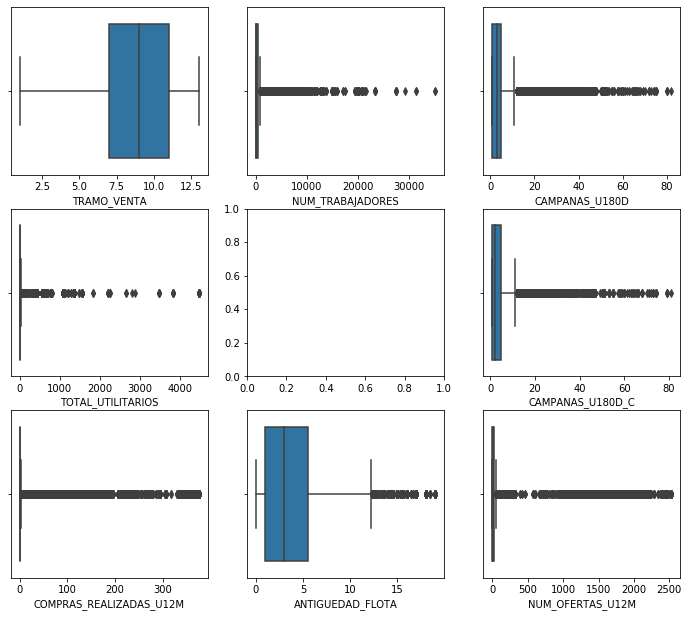

In [16]:
fig, axs = plt.subplots(3,3, figsize = (12,10.5))
plt2 = sns.boxplot(df['TRAMO_VENTA'], ax = axs[0,0])
plt2 = sns.boxplot(df['NUM_TRABAJADORES'], ax = axs[0,1])
plt2 = sns.boxplot(df['TOTAL_UTILITARIOS'], ax = axs[1,0])
plt2 = sns.boxplot(df['ANTIGUEDAD_FLOTA'], ax = axs[2,1])
plt2 = sns.boxplot(df['CAMPANAS_U180D_C'], ax = axs[1,2])
plt2 = sns.boxplot(df['NUM_OFERTAS_U12M'], ax = axs[2,2])
plt2 = sns.boxplot(df['CAMPANAS_U180D'], ax = axs[0,2])
plt2 = sns.boxplot(df['COMPRAS_REALIZADAS_U12M'], ax = axs[2,0])

plt.show()

ahi un exceso de variabilidad en algunas columnas

In [17]:
#estas variables no pueden ser imputadas porque indican que no tienen vehiculos, candidatas a irse de la base!!
df['TOTAL_UTILITARIOS'] = df['TOTAL_UTILITARIOS'].replace(np.nan,0)
df['UTILITARIOS_EXCLUSION'] = df['UTILITARIOS_EXCLUSION'].replace(np.nan,0)
df['RELEVANTE_CAMIONES'] = df['RELEVANTE_CAMIONES'].replace(np.nan,0)
df['RELEVANTE_OTROS'] = df['RELEVANTE_OTROS'].replace(np.nan,0)



df['TRAMO_VENTA'] = df['TRAMO_VENTA'].replace(np.nan, np.mean(df['TRAMO_VENTA']))
df['NUM_TRABAJADORES'] = df['NUM_TRABAJADORES'].replace(np.nan, np.mean(df['NUM_TRABAJADORES']))


### columnas categoricas

In [18]:
df[['MARCA_AGRUPADA','DESC_TIPO_VEHICULO']].describe()

,MARCA_AGRUPADA,DESC_TIPO_VEHICULO
count,212232,208079
unique,8,23
top,MERCEDES-BENZ,CAMION
freq,137074,45942


In [19]:
avr_mar=pd.DataFrame(df.groupby('MARCA_AGRUPADA')["COMPRO_NUM"].mean())
avr_mar=avr_mar.sort_values("COMPRO_NUM",ascending=False)
avr_mar.head(50)

,COMPRO_NUM
MARCA_AGRUPADA,
POWERSYSTEMS,0.243228
GREAT DANE,0.199203
TREMAC,0.116083
HEIL,0.088328
MERCEDES-BENZ,0.080292
FREIGHTLINER,0.058504
MITSUBISHI-FUSO,0.050209
WESTERN STAR,0.044444


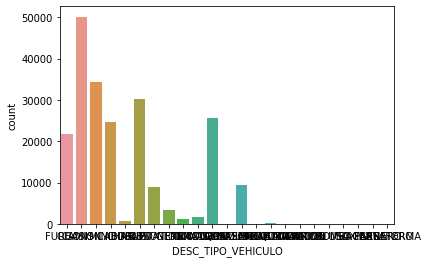

In [20]:
df['DESC_TIPO_VEHICULO'] = df['DESC_TIPO_VEHICULO'].replace(np.nan,'CAMION')
plt1 = sns.countplot(df['DESC_TIPO_VEHICULO'])
plt.show()

In [21]:
df[['FLOTA_NUEVA','ANTIGUEDAD_FLOTA']].describe()

,FLOTA_NUEVA,ANTIGUEDAD_FLOTA
count,106114.000000,106114.000000
mean,0.340181,3.711184
std,0.473772,3.154748
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,3.000000
75%,1.000000,5.500000
max,1.000000,19.000000


In [22]:
# estos valores corresponden a flotas, si estan vacion significa que no tienen flota o bien no tienen flota nueva
df['FLOTA_NUEVA'] = df['FLOTA_NUEVA'].replace(np.nan,0)

#se debe trabajar en esto
df['CAMPANAS_U180D'] = df['CAMPANAS_U180D'].replace(np.nan,0)
df['CAMPANAS_U180D_C'] = df['CAMPANAS_U180D_C'].replace(np.nan,0)
df['ANTIGUEDAD_FLOTA'] = df['ANTIGUEDAD_FLOTA'].replace(np.nan,0)

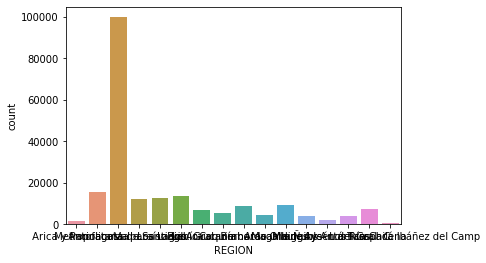

,REGION
count,208860
unique,16
top,Metropolitana de Santiago
freq,99903


In [23]:
plt1 = sns.countplot(df['REGION'])
plt.show(),
df[['REGION']].describe()

In [24]:
df['REGION'] = df['REGION'].replace(np.nan,'NA')

In [25]:
df[['COMUNA_CRM']].describe()

,COMUNA_CRM
count,211927
unique,362
top,SANTIAGO
freq,14222


In [26]:
df['COMUNA_CRM'] = df['COMUNA_CRM'].replace(np.nan,'NA')

In [27]:
df[['DESC_TIPO_VEHICULO']].describe()

,DESC_TIPO_VEHICULO
count,212232
unique,23
top,CAMION
freq,50095


In [28]:
df['DESC_TIPO_VEHICULO'] = df['DESC_TIPO_VEHICULO'].replace(np.nan,'NA')

In [29]:
df[['TIPO_CREDITO_USADO_ANT']].describe()

,TIPO_CREDITO_USADO_ANT
count,98611
unique,7
top,CONTADO
freq,62559


In [30]:
df['TIPO_CREDITO_USADO_ANT'] = df['TIPO_CREDITO_USADO_ANT'].replace(np.nan,'NA')

In [31]:
#cantidad de missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212232 entries, 0 to 212231
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   TIPO_CLIENTE              212232 non-null  object 
 1   RUBRO_ECON                212232 non-null  object 
 2   ANTIGUEDAD_E              212232 non-null  object 
 3   TRAMO_VENTA               212232 non-null  float64
 4   NUM_TRABAJADORES          212232 non-null  float64
 5   TOTAL_UTILITARIOS         212232 non-null  float64
 6   UTILITARIOS_EXCLUSION     212232 non-null  float64
 7   RELEVANTE_BUSES           212232 non-null  float64
 8   RELEVANTE_CAMIONES        212232 non-null  float64
 9   RELEVANTE_RODADOS         212232 non-null  float64
 10  RELEVANTE_VANS            212232 non-null  float64
 11  RELEVANTE_CARGA           212232 non-null  float64
 12  RELEVANTE_PASAJERA        212232 non-null  float64
 13  RELEVANTE_PESADO          212232 non-null  f

In [32]:
numericas = [['NUM_TRABAJADORES',
'TOTAL_UTILITARIOS',
'UTILITARIOS_EXCLUSION',
'RELEVANTE_BUSES',
'RELEVANTE_CAMIONES',
'RELEVANTE_RODADOS',
'RELEVANTE_VANS',
'RELEVANTE_CARGA',
'RELEVANTE_PASAJERA',
'RELEVANTE_PESADO',
'RELEVANTE_CAMIONETA',
'RELEVANTE_MEDIANO',
'RELEVANTE_OTROS',
'RELEVANTE_LIVIANO',
'RELEVANTE_CAMIONETA_DCAB',
'RELEVANTE_FORESTAL',
'RELEVANTE_CAMABAJA',
'FLOTA_NUEVA',
'ANTIGUEDAD_FLOTA',
'CAMPANAS_U180D',
'CAMPANAS_U180D_C',
'NUM_OFERTAS_U12M',
'COMPRAS_REALIZADAS_U12M',
'CAMPANAS_U180D_C',
'NUM_OFERTAS_U12M',
'COMPRAS_REALIZADAS_U12M']]

df1=df

for i in numericas:
    df1[i]=(df[i]-df1[i].mean())/df1[i].std()

In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212232 entries, 0 to 212231
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   TIPO_CLIENTE              212232 non-null  object 
 1   RUBRO_ECON                212232 non-null  object 
 2   ANTIGUEDAD_E              212232 non-null  object 
 3   TRAMO_VENTA               212232 non-null  float64
 4   NUM_TRABAJADORES          212232 non-null  float64
 5   TOTAL_UTILITARIOS         212232 non-null  float64
 6   UTILITARIOS_EXCLUSION     212232 non-null  float64
 7   RELEVANTE_BUSES           212232 non-null  float64
 8   RELEVANTE_CAMIONES        212232 non-null  float64
 9   RELEVANTE_RODADOS         212232 non-null  float64
 10  RELEVANTE_VANS            212232 non-null  float64
 11  RELEVANTE_CARGA           212232 non-null  float64
 12  RELEVANTE_PASAJERA        212232 non-null  float64
 13  RELEVANTE_PESADO          212232 non-null  f

## Exploración
Practicamente todos los grupos tienen una baja conversion pero existen diferencias en promedio

### Análisis por columna

 la variable COMPRO_NUM corresponde a una variable indicadora de si compra o no lo ofertado
#(1) compra (0) no compra

In [34]:
conversion = (sum(df1['COMPRO_NUM'])/len(df1['COMPRO_NUM'].index))*100
conversion

7.712314825285536

Una conversion tan baja requiere balance de la información

#### RUBRO_ECON

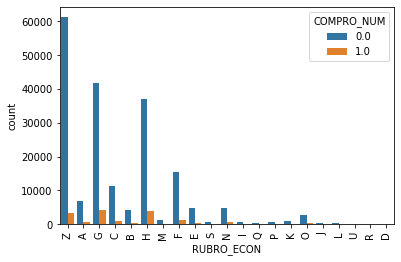

In [35]:
sns.countplot(x = "RUBRO_ECON", hue = "COMPRO_NUM", data = df1)
xticks(rotation = 90)
plt.show()

In [36]:
df1.groupby('RUBRO_ECON')["COMPRO_NUM"].mean() 

RUBRO_ECON
A    0.090921
B    0.068592
C    0.071257
D    0.040698
E    0.078757
F    0.069842
G    0.094826
H    0.092270
I    0.059809
J    0.078740
K    0.091837
L    0.098921
M    0.098731
N    0.099344
O    0.088889
P    0.097059
Q    0.045603
R    0.088435
S    0.098474
U    0.038462
Z    0.053477
Name: COMPRO_NUM, dtype: float64

#### ANTIGUEDAD_E

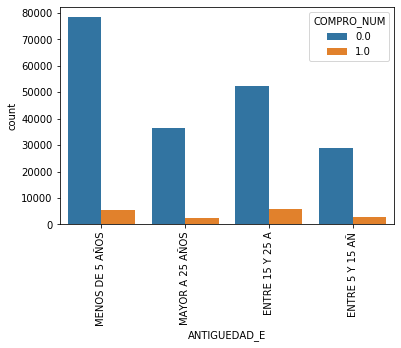

ANTIGUEDAD_E
ENTRE 15 Y 25 A    0.101447
ENTRE 5 Y 15 AÑ    0.089993
MAYOR A 25 AÑOS    0.060041
MENOS DE 5 AÑOS    0.063202
Name: COMPRO_NUM, dtype: float64

In [37]:
# la variable la optimize desde sas
sns.countplot(x = "ANTIGUEDAD_E", hue = "COMPRO_NUM", data = df1)
xticks(rotation = 90)
plt.show(),
df1.groupby('ANTIGUEDAD_E')["COMPRO_NUM"].mean() 


#### TRAMO_VENTA

In [38]:
df1.groupby('TRAMO_VENTA')["COMPRO_NUM"].mean() 

TRAMO_VENTA
1.000000     0.084308
2.000000     0.042511
3.000000     0.052659
4.000000     0.054204
5.000000     0.069831
6.000000     0.075005
7.000000     0.078158
8.000000     0.086408
8.862954     0.055464
9.000000     0.093551
10.000000    0.108782
11.000000    0.142489
12.000000    0.103281
13.000000    0.062625
Name: COMPRO_NUM, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

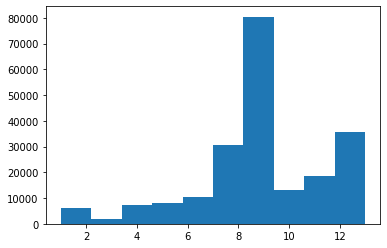

In [39]:
plt.hist(df1["TRAMO_VENTA"])
plt.show

### Numero de trabajadores

<function matplotlib.pyplot.show(*args, **kw)>

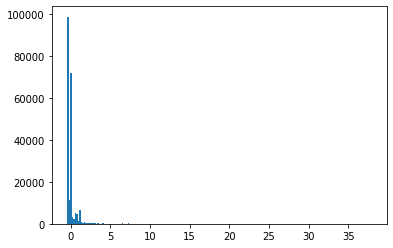

In [40]:
plt.hist(df1["NUM_TRABAJADORES"],bins=200)
plt.show



Existen aoutliers es esta variable

### REGION

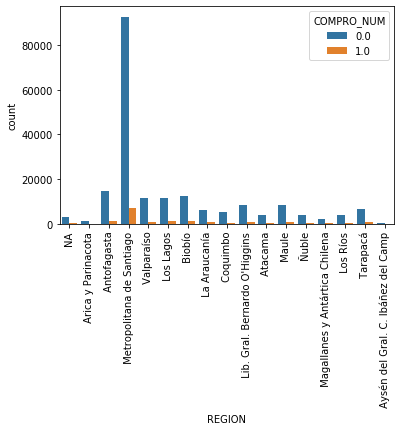

REGION
NA                                     0.055457
 Antofagasta                           0.062973
 Arica y Parinacota                    0.053402
 Atacama                               0.059837
 Aysén del Gral. C. Ibáñez del Camp    0.027842
 Biobío                                0.101514
 Coquimbo                              0.071220
 La Araucanía                          0.110455
 Lib. Gral. Bernardo O'Higgins         0.062145
 Los Lagos                             0.093520
 Los Ríos                              0.111512
 Magallanes y Antártica Chilena        0.089918
 Maule                                 0.093509
 Metropolitana de Santiago             0.071720
 Tarapacá                              0.091216
 Valparaíso                            0.064106
 Ñuble                                 0.096650
Name: COMPRO_NUM, dtype: float64

In [41]:
# la variable la optimize desde sas
sns.countplot(x = "REGION", hue = "COMPRO_NUM", data = df1)
xticks(rotation = 90)
plt.show(),
df1.groupby('REGION')["COMPRO_NUM"].mean() 


### Tipo credito usado anteriormente

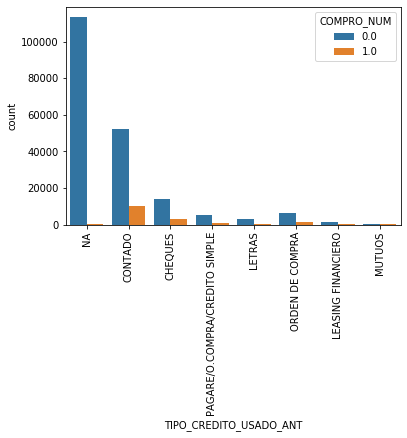

TIPO_CREDITO_USADO_ANT
CHEQUES                           0.178041
CONTADO                           0.161751
LEASING FINANCIERO                0.121805
LETRAS                            0.153653
MUTUOS                            0.155556
NA                                0.002306
ORDEN DE COMPRA                   0.189965
PAGARE/O.COMPRA/CREDITO SIMPLE    0.121955
Name: COMPRO_NUM, dtype: float64

In [42]:
sns.countplot(x = "TIPO_CREDITO_USADO_ANT", hue = "COMPRO_NUM", data = df1)
xticks(rotation = 90)
plt.show(),
df1.groupby('TIPO_CREDITO_USADO_ANT')["COMPRO_NUM"].mean() 

Esto tiene poca logica, pero se usa, si el cliente compra antes, tengo el tipo de credito que ocupa, pero voy a agrupar

In [43]:
df1['TIPO_CREDITO_USADO_ANT'] = df1['TIPO_CREDITO_USADO_ANT'].replace('PAGARE/O.COMPRA/CREDITO SIMPLE','CREDITO')
df1['TIPO_CREDITO_USADO_ANT'] = df1['TIPO_CREDITO_USADO_ANT'].replace('LEASING FINANCIERO','LEASING')

### Ofertas realizadas anteriormente

-0.05114622620301257

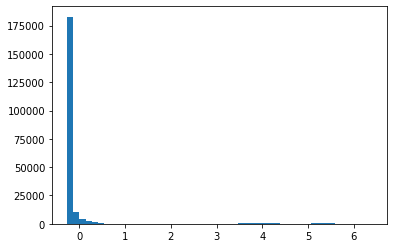

In [44]:
plt.hist(df1["NUM_OFERTAS_U12M"],bins=50)
plt.show

df1['NUM_OFERTAS_U12M'].corr(df1["COMPRO_NUM"])

### Servicios PV

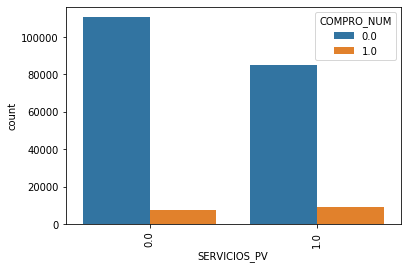

SERVICIOS_PV
0.0    0.062489
1.0    0.095462
Name: COMPRO_NUM, dtype: float64

In [45]:
sns.countplot(x = "SERVICIOS_PV", hue = "COMPRO_NUM", data = df1)
xticks(rotation = 90)
plt.show(),
df1.groupby('SERVICIOS_PV')["COMPRO_NUM"].mean() 

## Dummificacion de variables

In [46]:
def variables_dummy(dataset,variable):
    cat_dummies = pd.get_dummies(dataset[variable],prefix=variable)
    #.iloc[:,1:]
    data_new = dataset.join(cat_dummies)
    dataset = data_new.drop([variable],axis=1)
    return dataset

In [47]:
df3=df1

df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212232 entries, 0 to 212231
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   TIPO_CLIENTE              212232 non-null  object 
 1   RUBRO_ECON                212232 non-null  object 
 2   ANTIGUEDAD_E              212232 non-null  object 
 3   TRAMO_VENTA               212232 non-null  float64
 4   NUM_TRABAJADORES          212232 non-null  float64
 5   TOTAL_UTILITARIOS         212232 non-null  float64
 6   UTILITARIOS_EXCLUSION     212232 non-null  float64
 7   RELEVANTE_BUSES           212232 non-null  float64
 8   RELEVANTE_CAMIONES        212232 non-null  float64
 9   RELEVANTE_RODADOS         212232 non-null  float64
 10  RELEVANTE_VANS            212232 non-null  float64
 11  RELEVANTE_CARGA           212232 non-null  float64
 12  RELEVANTE_PASAJERA        212232 non-null  float64
 13  RELEVANTE_PESADO          212232 non-null  f

In [48]:
tabla=variables_dummy(df3,"TIPO_CLIENTE")
tabla=variables_dummy(tabla,"ANTIGUEDAD_E")
tabla=variables_dummy(tabla,"DESC_TIPO_VEHICULO")
tabla=variables_dummy(tabla,"MARCA_AGRUPADA")
tabla=variables_dummy(tabla,"RUBRO_ECON")
tabla=variables_dummy(tabla,"REGION")
#tabla=variables_dummy(tabla,"COMUNA_CRM")
tabla=variables_dummy(tabla,"USADO_NUEVO")
tabla=variables_dummy(tabla,"TIPO_CREDITO_USADO_ANT")

tabla=tabla.drop(["COMUNA_CRM"], axis=1)

In [49]:
y=tabla["COMPRO_NUM"]
x=tabla.drop(["COMPRO_NUM"], axis=1)

### Datos entrenamiento y testeo

como esta desbalanceado, primero divido la muestra pero por estratos

In [50]:
x_res,x_test,y_res,y_test=train_test_split(x,y,test_size=0.1,random_state=1010,stratify=y)

Revisamos como quedan las separaciones

In [51]:
y_res.mean(),y_test.mean(),y_res.shape,y_test.shape

(0.0771224241916569, 0.07712966453071994, (191008,), (21224,))

### Balanceo de datos de entrenamiento

Tengo la opcion de bajar o subir la muestra, a modo de no perder informacion se sube

In [52]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE 
nm = SMOTE(random_state = 10101) 
#nm = NearMiss()
#X_train, y_train = sm.fit_sample(x_res, y_res.ravel()) 

Using TensorFlow backend.


In [53]:
x_train,y_train=nm.fit_sample(x_res,y_res)

Reviso dimenciones nuevamente

In [54]:
y_res.shape, y_res.mean(), y_train.shape,y_train.mean()

((191008,), 0.0771224241916569, (352554,), 0.5)

paso de 191 mil datos de entrenamiento a 352, mediante resample

Guardado de bases finales

In [55]:
x_train.to_csv("x_train.csv")
y_train.to_csv("y_train.csv")
x_test.to_csv("x_test.csv")
y_test.to_csv("y_test.csv")

Carga de bases

In [31]:
x_train=pd.read_csv("x_train.csv")
y_train=pd.read_csv("y_train.csv")
x_test=pd.read_csv("x_test.csv")
y_test=pd.read_csv("y_test.csv")


y_train=y_train.COMPRO_NUM
y_test=y_test.COMPRO_NUM
x_train=x_train.drop(['Unnamed: 0'],axis=1)
x_test=x_test.drop(['Unnamed: 0'],axis=1)

# Modelamiento

La estrategia en este caso es utilizar regresion logistica, en el caso de obtener un pobre ajuste, se utilitan varios modelos para probar

## Regresion logistica

Utilizo regresion loistica y una busqueda por gridsearch para encontrar mejores hiperparametros

In [382]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg=LogisticRegression()

logreg_cv=GridSearchCV(logreg,grid,cv=5,verbose=10)

In [383]:
logreg_cv.fit(x_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.4s
[CV] C=0.001, penalty=l1 .............................................
[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] C=0.001, penalty=l1 .............................................
[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.3s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.807, total=  11.7s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.3s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.810, total=  11.7s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.0s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.811, total=  11.1s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.2s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.806, total=  11.8s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   48.0s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.810, total=  11.1s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .................. C=0.01, penalty=l2, score=0.805, total=  11.3s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .

[CV] ................ C=1000.0, penalty=l2, score=0.853, total=  11.5s
[CV] C=1000.0, penalty=l2 ............................................
[CV] ................ C=1000.0, penalty=l2, score=0.855, total=  11.3s
[CV] C=1000.0, penalty=l2 ............................................
[CV] ................ C=1000.0, penalty=l2, score=0.854, total=  11.8s


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  7.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [390]:
logreg_cv.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [388]:
mediciones(x_train,y_train,x_test,y_test,logreg_cv)

,Entrenamiento,Testeo
Accuracy,0.842,0.798
recall,0.875,0.626
roc,0.938,0.844


El accuracy es demasiado bajo, pero el recall se mantiene sano con un roc 84% es un buen candidato pero no uno optimo

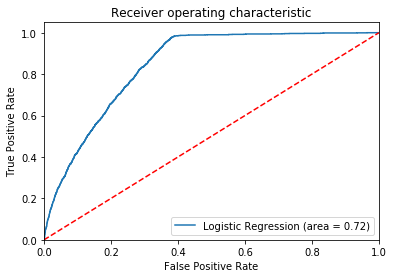

In [392]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg_cv.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_cv.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Se aprecia un claro bajo ajuste, veamos su aplicamos otros modelos podemos mejorar esto

## Multi-modelos

Para evita probar uno a uno los modelos, se seleccionan varios y luego se verifica los con mejor rendimiento para hacer una busqueda ampliada de los mejores con gridsearch

In [41]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier,StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier          
              

modelos = [["SVC","RF","TREE","MLP","GBOOST","ADABOOST"],
           [
            svm.LinearSVC(max_iter=30),
            RandomForestClassifier(max_depth=12,n_estimators=80,random_state=0),
            DecisionTreeClassifier(max_depth=30),
            MLPClassifier(alpha=0.1,hidden_layer_sizes=14,random_state= 10101,solver='lbfgs'),
            GaussianNB(),
            AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30))]
          ]
warnings.filterwarnings("ignore")

Inicio de loop

In [42]:
resultados=[]
predicion=[]
error=[]
precision=[]
a=0
for i in modelos[1]:
    ajuste=i.fit(x_train,y_train)
    resultados.append(ajuste)
    predicion.append(ajuste.predict(x_test))
    er = i.score(x_test,y_test)
    error.append(er)
    precision.append(ajuste.score(x_test , y_test))
    print("modelo:",modelos[0][a])
    print(mediciones2(x_train,y_train,x_test,y_test,ajuste))
    print(confusion_matrix(y_test,ajuste.predict(x_test)))
    print("f1 score:",f1_score(y_test,ajuste.predict(x_test)))
    if modelos[0][a]!='SVC':
        print("roc-auc:", roc_auc_score(y_test,ajuste.predict_proba(x_test)[:,1]))
    a=a+1

modelo: SVC
          Testeo
Accuracy   0.900
recall     0.131
[[18891   696]
 [ 1421   216]]
f1 score: 0.1694782267555904
modelo: RF
          Testeo
Accuracy   0.709
recall     0.888
[[13598  5989]
 [  183  1454]]
f1 score: 0.32026431718061676
roc-auc: 0.8592316335379964
modelo: TREE
          Testeo
Accuracy   0.889
recall     0.391
[[18230  1357]
 [  996   641]]
f1 score: 0.3526822558459422
roc-auc: 0.7005861011562561
modelo: MLP
          Testeo
Accuracy   0.806
recall     0.590
[[16161  3426]
 [  671   966]]
f1 score: 0.32045115276165204
roc-auc: 0.8421890973464599
modelo: GBOOST
          Testeo
Accuracy   0.651
recall     0.920
[[12312  7275]
 [  130  1507]]
f1 score: 0.2892792014588732
roc-auc: 0.7740739209077967
modelo: ADABOOST
          Testeo
Accuracy   0.898
recall     0.339
[[18512  1075]
 [ 1082   555]]
f1 score: 0.3397612488521579
roc-auc: 0.8116593919788783


Siguiente paso es usar gridsearch para buscar la mejor version de cada uno usando como referencia para los mejores, el accuracy o roc

Los modelos que revisare en mayor profundidad son la rn, adaboost y randomforest

## Adaboost con grid search

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'base_estimator__max_depth':[1,20,50,80]}

gs = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), params,cv=3,verbose=10,n_jobs=-1)

#print(gs.best_estimator_)

In [7]:
gs.fit(x_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  2.2min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 13.1min remaining: 18.3min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 13.4min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 13.9min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [8]:
gs.best_params_

{'base_estimator__max_depth': 20}

In [9]:
mediciones(x_train,y_train,x_test,y_test,gs)

,Entrenamiento,Testeo
Accuracy,0.983,0.901
recall,0.983,0.338
roc,0.999,0.822


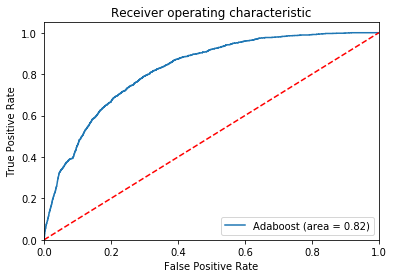

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, gs.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gs.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Adaboost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Teniendo en cuenta los ajustes actuales es un buen ajuste pero el recall es muy bajo, veamos mas opciones

## Clasificador por Multi-Layer-Perc.  (RN)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

parameters = {'solver': ['lbfgs'], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[10101]}
mlp_cv = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1,verbose=10,cv=3)


In [12]:
mlp_cv.fit(x_train,y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 36.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.

In [16]:
mlp_cv.best_params_

{'alpha': 0.1,
 'hidden_layer_sizes': 14,
 'random_state': 10101,
 'solver': 'lbfgs'}

In [14]:
mediciones(x_train,y_train,x_test,y_test,mlp_cv)

,Entrenamiento,Testeo
Accuracy,0.850,0.806
recall,0.875,0.590
roc,0.942,0.842


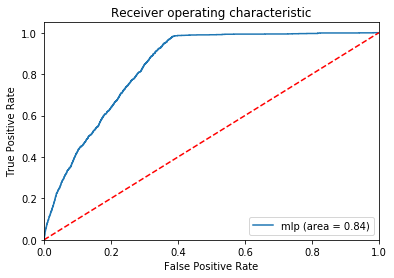

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, mlp_cv.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, mlp_cv.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='mlp (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Mejora el recall pero caemos en el accuracy, igualmente roc esta muy bueno

## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators'      : [50,80,100,140,200],
    'max_depth'         : [8, 9, 10],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}

rf_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=3, n_jobs=-1,verbose=10)

In [44]:
rf_cv.fit(x_train,y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 59.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [45]:
rf_cv.best_params_

{'max_depth': 30, 'n_estimators': 200, 'random_state': 0}

In [46]:
mediciones(x_train,y_train,x_test,y_test,rf_cv)

,Entrenamiento,Testeo
Accuracy,0.973,0.882
recall,0.987,0.389
roc,0.997,0.861


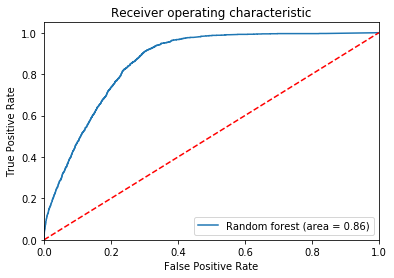

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rf_cv.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, rf_cv.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
print(confusion_matrix(y_test,rf_cv.predict(x_test)))

[[18100  1487]
 [ 1000   637]]


Ya tengo la mejor version de estos 3 modelos, antes de escojer uno de ellos ¿juntemoslos todos y veamos si la union de todos es mejor que uno solo?

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

modelos =[('ada',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20))),
('mlp',MLPClassifier(alpha=0.1,hidden_layer_sizes=14,random_state= 10101,solver='lbfgs')),
('rfc',RandomForestClassifier(max_depth=12,n_estimators=80,random_state=0))]



modelo_salida = LogisticRegression(C= 100.0, penalty= 'l2')

#voy a forzarlo a usar las variables predictoras con las predichas
stack=StackingClassifier(estimators=modelos, final_estimator=modelo_salida,n_jobs=1,passthrough=True,verbose=10)

In [21]:
stack.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

StackingClassifier(cv=None,
                   estimators=[('ada',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                         class_weight=None,
                                                                                         criterion='gini',
                                                                                         max_depth=20,
                                                                                         max_features=None,
                                                                                         max_leaf_nodes=None,
                                                                                         min_impurity_decrease=0.0,
                                                                                         min_impurity_spl

In [22]:
mediciones(x_train,y_train,x_test,y_test,stack)

,Entrenamiento,Testeo
Accuracy,0.977,0.895
recall,0.984,0.379
roc,0.998,0.867


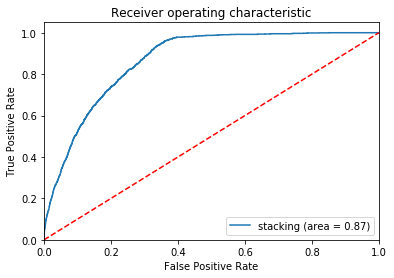

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, stack.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, stack.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='stacking (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [25]:
#stack matriz confucion
print(confusion_matrix(y_test,stack.predict(x_test)))

[[18391  1196]
 [ 1016   621]]


Desde mi punto de vista la mejor opcion es random forest, debido a que el recall no es tan bajo y el roc esta bien.